<a href="https://colab.research.google.com/github/anyuanay/Bayesian-Methods-for-Machine-Learning/blob/master/sBERT_RTER_distant_evidence_denoising_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RTER (Relevant Textual Evidence Recognition)
# Discovering Highly Relevant Textual Evidence through Denoising the Distant Evidence (Currently working document with Sentence-BERT)


### Yuan An revisited on Feb.11, 2020
### Yuan An revisited on May 26, 2020 using colab
Original Notebook: deepNLP/RTER/RTER-distant-evidence-denoising-embeddings.ipynb

In this study, we will experiment with the following embedding techniques for discovering the highly relevant textual evidence for the relations in a knowledge base.
* Sentence-BERT: https://github.com/anyuanay/sentence-transformers
* doc2vec by gensim: https://radimrehurek.com/gensim/models/doc2vec.html
* Skip-thoughts sent2vec: https://github.com/ryankiros/skip-thoughts
* Context-Aware Relation Extraction: https://github.com/anyuanay/emnlp2017-relation-extraction
* CoType Relation Extraction: https://github.com/RaniemAR/CoType
* Tensorflow-NRE: https://github.com/dddragons/TensorFlow-NRE

## In this notebook, we will load the data sets and test embedding methods for distant evidence denoising
* Low-cost annotation to relations in knowledge bases -> using embeddings to denoise

# We Begin with the Sentences in CoType NYT Data Sets - Test Data First

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import logging
#enable logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Loading the annotated data including sentences, entities, and relations

In [0]:
# This function takes a path as parameter and loads the Json file into a list of json objects
def loadJson(jfile):
    """
    This function takes a path as the argument and loads the Json file into a list of json objects
    
    Arguments:
    jfile -- a path pointing to a file containing Json objects in text format
    
    Return:
    jsons -- a list of Json objects
    """
    jsons = []
    with open(jfile) as f:
        for line in f:
            jsons.append(json.loads(line))
    
    return jsons

In [0]:
def makeDFFromJson(jsons):
    """
    This function takes a list of Json objects as the argument, it then flattens the Json objects, and creates
    a data frame
    
    Arguments:
    jsons --  a list of Json objects representing the annotations of sentences
    
    Return:
    df --  a data frame representing the flattened annotations.
    
    """
    sentId_list= []
    articleId_list = []
    em1_list = []
    em2_list = []
    em1label_list = []
    em2label_list = []
    em1start_list = []
    em2start_list = []
    relation_list = []
    sentText_list = []

    for annot in jsons:
        for relMention in annot['relationMentions']:
            em1 = relMention['em1Text']
            em2 = relMention['em2Text']
            em1lbl = ""
            em2lbl = ""
            em1start = 0
            em2start = 0
            for entityMention in annot['entityMentions']:
                if em1 == entityMention['text']:
                    em1lbl = entityMention['label']
                    em1start = entityMention['start']
                if em2 == entityMention['text']:
                    em2lbl = entityMention['label']
                    em2start =entityMention['start']

            sentId_list.append(annot['sentId'])
            articleId_list.append(annot['articleId'])
            em1_list.append(em1)
            em2_list.append(em2)
            em1label_list.append(em1lbl)
            em2label_list.append(em2lbl)
            em1start_list.append(em1start)
            em2start_list.append(em2start)
            relation_list.append(relMention['label'])
            sentText_list.append(annot['sentText'])
        
    data = {"sentId" : sentId_list, "articleId" : articleId_list, "em1":em1_list, "em1label":em1label_list,\
                           "em1start":em1start_list, "em2":em2_list, "em2label":em2label_list, "em2start":em2start_list, 
                           "relation":relation_list, "sentText":sentText_list}
    #index=np.arange(len(sentId_list))
    df = pd.DataFrame(data=data)
    
    return df

#### Load coType NYT Test Data

In [0]:
import json
import pandas as pd
jsons = loadJson("../data/coType-data/NYT/test.json")
NYT_test_df = makeDFFromJson(jsons)

In [0]:
len(jsons) # the total number of sentences

395

### The start information in the entity mentions gives the position of an entity in the sentence among all labeled entities. It is not the index of characters where the entity starts in the sentence.

In [0]:
NYT_test_df.head(10)

,sentId,articleId,em1,em1label,em1start,em2,em2label,em2start,relation,sentText
0,33,2,Tim Pawlenty,PERSON,0,Minnesota,LOCATION,1,/people/person/place_lived,Gov. Tim Pawlenty of Minnesota ordered the sta...
1,33,2,Minnesota,LOCATION,1,Tim Pawlenty,PERSON,0,None,Gov. Tim Pawlenty of Minnesota ordered the sta...
2,14,1,Guinea,LOCATION,1,Conakry,LOCATION,2,/location/country/capital,"""The aid group Doctors Without Borders said th..."
3,14,1,Conakry,LOCATION,2,Guinea,LOCATION,1,None,"""The aid group Doctors Without Borders said th..."
4,44,1,Ben Nelson,PERSON,0,Nebraska,LOCATION,1,/people/person/place_lived,"""The American people can see what is happening..."
5,44,1,Nebraska,LOCATION,1,Ben Nelson,PERSON,0,None,"""The American people can see what is happening..."
6,10,5,Westchester,LOCATION,4,New Rochelle,LOCATION,6,None,"""For millions , it was a tough day of coping -..."
7,10,5,New Rochelle,LOCATION,6,Westchester,LOCATION,4,None,"""For millions , it was a tough day of coping -..."
8,10,5,New Jersey,LOCATION,1,New Brunswick,LOCATION,2,None,"""For millions , it was a tough day of coping -..."
9,10,5,New Brunswick,LOCATION,2,New Jersey,LOCATION,1,None,"""For millions , it was a tough day of coping -..."


In [0]:
NYT_test_df.shape

(3880, 10)

In [0]:
NYT_test_df.iloc[4]['sentText']

'"The American people can see what is happening here , \'\' said Senator Ben Nelson , Democrat of Nebraska . \'\'"\r\n'

In [0]:
NYT_test_df.iloc[4]

sentId                                                      44
articleId                                                    1
em1                                                 Ben Nelson
em1label                                                PERSON
em1start                                                     0
em2                                                   Nebraska
em2label                                              LOCATION
em2start                                                     1
relation                            /people/person/place_lived
sentText     "The American people can see what is happening...
Name: 4, dtype: object

#### Remove None annotation

In [0]:
NYT_test_df[NYT_test_df.relation == "None"].iloc[2010]

sentId                                                       2
articleId                                                    7
em1                                          Surayud Chulanont
em1label                                                PERSON
em1start                                                     0
em2                                                   Thailand
em2label                                              LOCATION
em2start                                                     1
relation                                                  None
sentText     "Prime Minister Surayud Chulanont of Thailand ...
Name: 2247, dtype: object

In [0]:
NYT_test_df_nn = NYT_test_df[NYT_test_df.relation != "None"]
NYT_test_df_nn.shape

(410, 10)

In [0]:
# 410 > 395 the total number of sentences. Some sentences have multiple relations.
NYT_test_df_nn[NYT_test_df_nn[['sentId', 'articleId']].duplicated()]

,sentId,articleId,em1,em1label,em1start,em2,em2label,em2start,relation,sentText
246,1,0,Sony,ORGANIZATION,3,Akio Morita,PERSON,2,/business/company/founders,"""Sony Corporation wishes to express its deepes..."
302,16,0,Ralph de la Vega,PERSON,2,AT&T,ORGANIZATION,3,/business/person/company,"""This is the first of many products that are g..."
479,36,0,Michoacan,,0,Mexico,LOCATION,1,/location/administrative_division/country,The government in the state of Michoacán promi...
515,1,146,Gaza,LOCATION,3,Israel,LOCATION,4,/location/administrative_division/country,"""The trucks entered Gaza from Israel at the Ke..."
708,26,2,Washington,LOCATION,11,Olympia,LOCATION,10,/location/location/contains,"""Dear father of Leslie M. Cross of Long Island..."
1692,7,6,Iran,LOCATION,2,Syria,LOCATION,5,/location/administrative_division/country,"""While majority Sunni , Syria is led by Alawit..."
1894,1,78,Russia,LOCATION,5,Iran,LOCATION,6,/location/administrative_division/country,"""The United States previously offered to locat..."
2306,2,4,Bihar,LOCATION,2,India,LOCATION,3,/location/administrative_division/country,"""On Thursday , more than 30 people were report..."
2551,1,48,Israel,LOCATION,2,Jerusalem,LOCATION,3,/location/location/contains,"""Teddy Kollek , who as mayor of Jerusalem for ..."
2590,35,1,Paris,LOCATION,3,Ecole Normale Superieure,,0,/location/location/contains,"""Born in Paris on Oct. 24 , 1932 , Pierre-Gill..."


In [0]:
NYT_test_df_nn[(NYT_test_df_nn.sentId==16) & (NYT_test_df_nn.articleId=='0')]

,sentId,articleId,em1,em1label,em1start,em2,em2label,em2start,relation,sentText
293,16,0,Ralph de la Vega,PERSON,2,AT&T,ORGANIZATION,3,/business/person/company,"""This is the first of many products that are g..."
302,16,0,Ralph de la Vega,PERSON,2,AT&T,ORGANIZATION,3,/business/person/company,"""This is the first of many products that are g..."


In [0]:
# Remove duplicated rows
NYT_test_df_nnd = NYT_test_df_nn.drop_duplicates()

In [0]:
# Group the annotations by "relation"
NYT_test_df_nnd.groupby("relation").count()

,sentId,articleId,em1,em1label,em1start,em2,em2label,em2start,sentText
relation,,,,,,,,,
/business/company/founders,4,4,4,4,4,4,4,4,4
/business/person/company,37,37,37,37,37,37,37,37,37
/location/administrative_division/country,102,102,102,102,102,102,102,102,102
/location/country/administrative_divisions,3,3,3,3,3,3,3,3,3
/location/country/capital,2,2,2,2,2,2,2,2,2
/location/location/contains,176,176,176,176,176,176,176,176,176
/location/neighborhood/neighborhood_of,1,1,1,1,1,1,1,1,1
/people/deceased_person/place_of_death,2,2,2,2,2,2,2,2,2
/people/person/children,2,2,2,2,2,2,2,2,2


In [0]:
NYT_test_df_nnd[NYT_test_df_nnd.relation == '/business/company/founders'].iloc[2].sentText

'"For Mrs. Clinton , the strategy for reaching black voters at this early stage of the campaign involves strong outreach to black elected officials , business leaders and others , followed by phone calls to reinforce her candidacy from her husband and supporters like Robert L. Johnson , who founded Black Entertainment Television ."\r\n'

In [0]:
NYT_test_df_nnd.tail()

,sentId,articleId,em1,em1label,em1start,em2,em2label,em2start,relation,sentText
3852,12,6,Kent Conrad,PERSON,1,North Dakota,LOCATION,2,/people/person/place_lived,"""Mr. Bernanke 's tone of urgency echoed the co..."
3858,3,0,Kwame Anthony Appiah,PERSON,0,Princeton University,ORGANIZATION,1,/business/person/company,"""THE WAY WE LIVE NOW : 3-18-07 Kwame Anthony A..."
3861,38,0,Rockland County,LOCATION,2,New City,LOCATION,1,/location/location/contains,"""DREXLER -- Beatrice C. , who ran Candy Mounta..."
3872,12,5,Sheldon Whitehouse,PERSON,2,Rhode Island,LOCATION,3,/people/person/place_lived,"""In another letter on Tuesday , two Democratic..."
3878,39,1,Imelda Marcos,PERSON,0,Philippines,LOCATION,1,/people/person/nationality,"""Songs From ` Here Lies Love ' '' offered 20 s..."


In [0]:
# Reset the index to be in the range (0, 395)
NYT_test_df_nnd.index = range(len(NYT_test_df_nnd.index))
NYT_test_df_nnd.tail()

,sentId,articleId,em1,em1label,em1start,em2,em2label,em2start,relation,sentText
391,12,6,Kent Conrad,PERSON,1,North Dakota,LOCATION,2,/people/person/place_lived,"""Mr. Bernanke 's tone of urgency echoed the co..."
392,3,0,Kwame Anthony Appiah,PERSON,0,Princeton University,ORGANIZATION,1,/business/person/company,"""THE WAY WE LIVE NOW : 3-18-07 Kwame Anthony A..."
393,38,0,Rockland County,LOCATION,2,New City,LOCATION,1,/location/location/contains,"""DREXLER -- Beatrice C. , who ran Candy Mounta..."
394,12,5,Sheldon Whitehouse,PERSON,2,Rhode Island,LOCATION,3,/people/person/place_lived,"""In another letter on Tuesday , two Democratic..."
395,39,1,Imelda Marcos,PERSON,0,Philippines,LOCATION,1,/people/person/nationality,"""Songs From ` Here Lies Love ' '' offered 20 s..."


In [0]:
NYT_test_df_nnd.iloc[392, 9]

'"THE WAY WE LIVE NOW : 3-18-07 Kwame Anthony Appiah , a philosopher at Princeton University , is the editor , with Martin Bunzl , of \'\' Buying Freedom : The Ethics and Economics of Slave Redemption , \'\' coming this fall ."\r\n'

In [0]:
NYT_test_df_nnd.iloc[390, 8]

'/people/person/nationality'

## The following dictionary rel2idx contains maps from relation names to a unique index

In [0]:
unique_rel = NYT_test_df_nnd["relation"].unique()
rel2idx = {rel:id+1 for id, rel in enumerate(unique_rel)}
rel2idx

{'/people/person/place_lived': 1,
 '/location/country/capital': 2,
 '/location/location/contains': 3,
 '/location/administrative_division/country': 4,
 '/business/person/company': 5,
 '/people/person/nationality': 6,
 '/people/person/children': 7,
 '/business/company/founders': 8,
 '/location/neighborhood/neighborhood_of': 9,
 '/location/country/administrative_divisions': 10,
 '/people/person/place_of_birth': 11,
 '/people/deceased_person/place_of_death': 12}

### Set up a column with the indices of relations

In [0]:
NYT_test_df_nnd["relIdx"] = NYT_test_df_nnd["relation"].map(rel2idx)

/home/ubuntu/anaconda3/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
NYT_test_df_nnd.iloc[335:340]

,sentId,articleId,em1,em1label,em1start,em2,em2label,em2start,relation,sentText,relIdx
335,2,0,Mark Crispin Miller,PERSON,0,New York University,ORGANIZATION,1,/business/person/company,"""It 's so hypocritical for any network in this...",5
336,1,13,Havana,LOCATION,4,Cuba,LOCATION,0,/location/administrative_division/country,"""I 'm particularly concerned that the dissiden...",4
337,1,104,Iran,LOCATION,1,Russia,LOCATION,3,/location/administrative_division/country,"""Even as the United States intensifies its eff...",4
338,4,9,Damascus,LOCATION,1,Syria,LOCATION,0,/location/administrative_division/country,"""INTERNATIONAL A3-11 Poverty Stricken Iraqis T...",4
339,2,8,Mexico,LOCATION,3,Guadalajara,LOCATION,2,/location/location/contains,"""The false statements included a claim to have...",3


In [0]:
NYT_test_df_nnd.shape

(396, 11)

(array([ 42., 176., 102.,  37.,  26.,   2.,   4.,   1.,   3.,   3.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

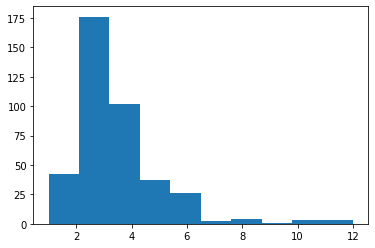

In [0]:
plt.hist(NYT_test_df_nnd["relIdx"])

In [0]:
NYT_test_df_nnd.groupby("relation", as_index=True).count().sort_values(by = "relIdx", ascending=False)

,sentId,articleId,em1,em1label,em1start,em2,em2label,em2start,sentText,relIdx
relation,,,,,,,,,,
/location/location/contains,176,176,176,176,176,176,176,176,176,176
/location/administrative_division/country,102,102,102,102,102,102,102,102,102,102
/people/person/place_lived,40,40,40,40,40,40,40,40,40,40
/business/person/company,37,37,37,37,37,37,37,37,37,37
/people/person/nationality,26,26,26,26,26,26,26,26,26,26
/business/company/founders,4,4,4,4,4,4,4,4,4,4
/location/country/administrative_divisions,3,3,3,3,3,3,3,3,3,3
/location/country/capital,2,2,2,2,2,2,2,2,2,2
/people/deceased_person/place_of_death,2,2,2,2,2,2,2,2,2,2


In [0]:
NYT_test_df_nnd.describe(include=['O'])

,articleId,em1,em1label,em2,em2label,relation,sentText
count,396,396,396,396,396,396,396
unique,70,197,4,233,4,12,388
top,0,France,LOCATION,Israel,LOCATION,/location/location/contains,"""A writer 's yearlong journey in search of sel..."
freq,135,17,281,15,302,176,3


## Test Sentence-BERT vectorizations

In [0]:
from sentence_transformers import SentenceTransformer

2020-02-19 13:39:23,295 : INFO : TensorFlow version 2.1.0 available.
2020-02-19 13:39:23,297 : INFO : PyTorch version 1.3.1 available.


In [0]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

2020-02-19 13:39:25,511 : INFO : Load pretrained SentenceTransformer: bert-base-nli-mean-tokens
2020-02-19 13:39:25,513 : INFO : Did not find a / or \ in the name. Assume to download model from server
2020-02-19 13:39:25,518 : INFO : Load SentenceTransformer from folder: /home/ubuntu/.cache/torch/sentence_transformers/public.ukp.informatik.tu-darmstadt.de_reimers_sentence-transformers_v0.2_bert-base-nli-mean-tokens.zip
2020-02-19 13:39:25,537 : INFO : loading configuration file /home/ubuntu/.cache/torch/sentence_transformers/public.ukp.informatik.tu-darmstadt.de_reimers_sentence-transformers_v0.2_bert-base-nli-mean-tokens.zip/0_BERT/config.json
2020-02-19 13:39:25,540 : INFO : Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attentio

In [0]:
sentences = NYT_test_df_nnd['sentText']

In [0]:
sent_embs = model.encode(sentences)

Batches: 100%|██████████| 50/50 [00:35<00:00,  1.41it/s]


In [0]:
sent_embs[4]

array([-1.23281389e-01,  7.76059508e-01,  2.28135943e-01, -1.25697777e-01,
        6.72638342e-02, -4.67236876e-01,  7.87840188e-01,  1.07661046e-01,
        8.35854828e-01, -3.00407261e-01, -9.50481474e-01,  4.75550175e-01,
        5.02443850e-01,  5.26224315e-01, -6.13158822e-01,  1.95118785e-01,
       -2.34951064e-01,  1.58319890e-01,  1.77152678e-01,  5.06143630e-01,
       -7.65719414e-02, -9.60364714e-02,  3.32929268e-02, -8.91877785e-02,
        9.02946949e-01,  4.34981316e-01,  1.91007420e-01, -5.04744768e-01,
       -7.06303358e-01,  1.95715085e-01,  1.90159246e-01, -1.54161632e-01,
       -9.73814666e-01, -2.23520473e-01,  2.96536177e-01,  1.04496753e+00,
        4.98159379e-01,  1.80067584e-01, -1.61149845e-01, -7.10619092e-01,
       -8.71330321e-01, -4.88316089e-01, -4.59994286e-01,  2.82975674e-01,
        3.24063450e-01, -1.04009712e+00,  1.44608712e+00,  8.80915523e-01,
        2.29500514e-02, -1.10484934e+00,  1.05824344e-01,  2.04383656e-01,
        9.33803320e-01,  

In [0]:
from sklearn.decomposition import PCA

In [0]:
embs_pca = PCA(n_components=2).fit_transform(sent_embs)
embs_pca.shape

(396, 2)

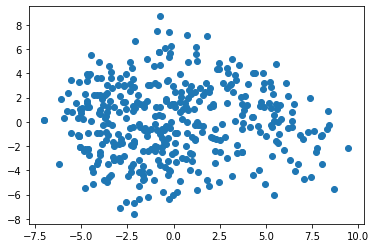

In [0]:
plt.scatter(embs_pca[:,0], embs_pca[:,1])

In [0]:
# Make a DataFrame from the embs_pca and their relation labels
embs_pca_df = pd.DataFrame(embs_pca)

In [0]:
NYT_test_df_nnd.columns

Index(['sentId', 'articleId', 'em1', 'em1label', 'em1start', 'em2', 'em2label',
       'em2start', 'relation', 'sentText', 'relIdx'],
      dtype='object')

In [0]:
embs_pca_df.columns = ['coord1', 'coord2']
embs_pca_df.head(1)

,coord1,coord2
0,-0.219593,7.364112


In [0]:
embs_pca_df['rels'] = NYT_test_df_nnd['relation']

In [0]:
embs_pca_df.head()

,coord1,coord2,rels
0,-0.219593,7.364112,/people/person/place_lived
1,-4.471837,5.472587,/location/country/capital
2,1.820778,-4.787438,/people/person/place_lived
3,0.957437,2.971852,/location/location/contains
4,7.588671,-0.775392,/location/administrative_division/country


In [0]:
import seaborn as sns
seaborn.set(style='ticks')

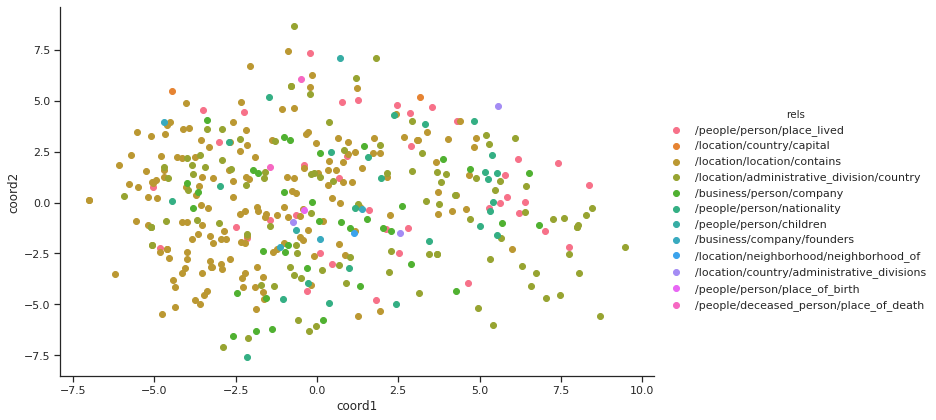

In [0]:
fg = seaborn.FacetGrid(data=embs_pca_df, hue='rels', height=6, aspect=1.61)
fg.map(plt.scatter, 'coord1', 'coord2').add_legend()

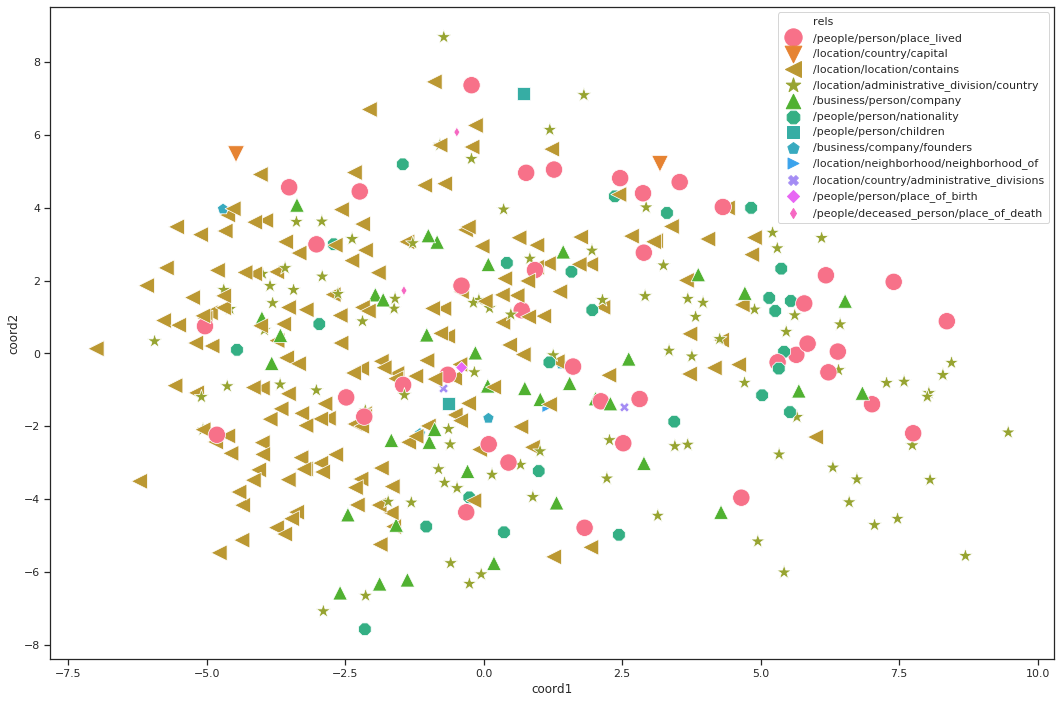

In [0]:
plt.figure(figsize=(18,12))
marker = ['o', 'v', '<', '*', '^', '8', 's', 'p', '>', 'X', 'D', 'd']
markers = [marker[i] for i in range(len(embs_pca_df["rels"].unique()))]
sns.scatterplot( x="coord1", y="coord2", data=embs_pca_df, hue='rels', style='rels', size='rels', 
                markers=markers, sizes=(50,300))

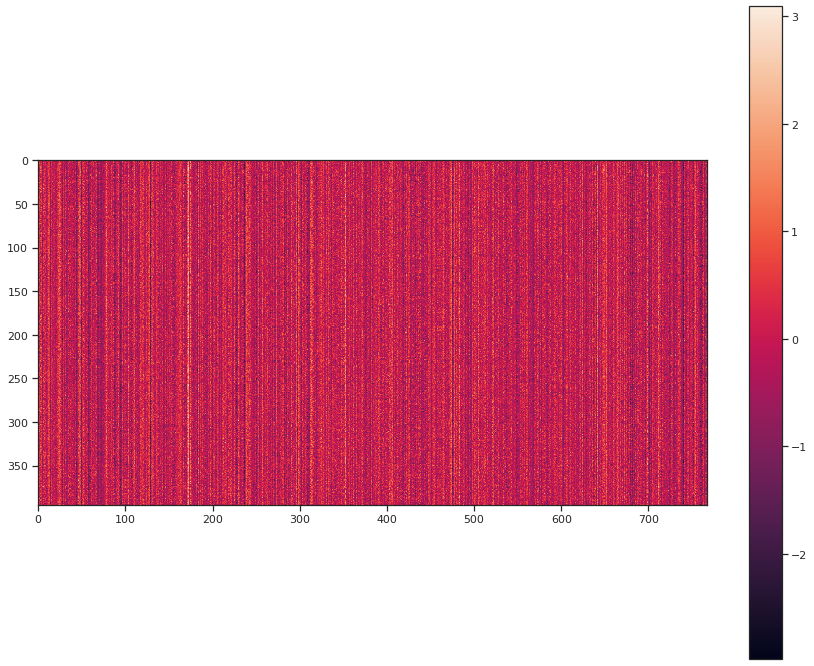

In [0]:
# Visualize the embeddings
plt.figure(figsize=(15, 12))
plt.imshow(sent_embs)
plt.colorbar()

In [0]:
#Sort the embeddings by the relation labels
embs_df = pd.DataFrame(sent_embs)

In [0]:
embs_df['rels'] = NYT_test_df_nnd['relation']

In [0]:
embs_df.head()

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,rels
0,-0.263522,0.648870,0.085061,-0.008925,0.324135,0.108028,1.254813,-0.312877,-0.009203,-0.726778,...,0.404910,-0.974529,-0.822392,0.648078,-0.565984,-0.036493,0.079456,0.393562,0.271115,/people/person/place_lived
1,0.064175,0.331233,0.145771,-0.118505,0.217049,0.149297,-0.140238,0.243811,-0.410109,-0.529677,...,0.170927,-0.939335,-0.046828,1.007327,-0.656611,-0.470842,0.337834,0.833790,0.065888,/location/country/capital
2,-0.225586,0.743517,0.293346,-0.127385,-0.139256,-0.827887,0.309263,0.086654,-0.162243,-0.482534,...,-0.048905,-0.851858,-0.980441,0.520023,-0.650668,-0.091764,0.123596,0.357012,-0.385306,/people/person/place_lived
3,0.091143,0.470455,0.905219,0.056780,0.388291,-0.228920,0.461507,0.031641,0.364382,-0.590010,...,-0.539158,-0.882209,-0.923474,0.515023,-0.987150,-0.208241,-0.201144,-0.205488,-0.138355,/location/location/contains
4,-0.123281,0.776060,0.228136,-0.125698,0.067264,-0.467237,0.787840,0.107661,0.835855,-0.300407,...,-0.114973,-0.157508,-1.076068,0.451363,-1.023936,0.044110,-0.028067,-0.413147,0.116247,/location/administrative_division/country


In [0]:
embs_df_sorted = embs_df.sort_values('rels')
embs_df_sorted

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,rels
26,-0.899757,1.343843,0.604150,-0.088744,0.087021,-0.951783,-0.199929,0.138172,0.432055,-0.466797,...,-1.051870,-0.507455,-1.455143,0.550145,-0.547093,-0.063188,0.639767,-0.193090,-0.428969,/business/company/founders
123,-0.564924,0.465410,0.164334,-0.236064,1.080767,-0.147949,0.065728,-0.770655,0.142435,-0.439611,...,-1.748590,-1.652018,-0.903819,0.290181,-0.705210,-0.085025,-0.538364,-0.647450,-0.256558,/business/company/founders
167,-0.343085,0.086759,0.212478,-0.094981,0.779142,-1.137185,0.026225,-0.274141,0.590086,0.094314,...,-0.844706,-0.819880,-0.844142,0.150595,-0.284792,0.462268,-0.577976,0.291010,-0.063068,/business/company/founders
42,-0.470904,0.685370,-0.228670,-0.153747,0.962056,-0.265377,-0.367101,1.072474,-0.398601,-0.246692,...,-0.196752,-0.322524,0.362002,0.575678,-0.276352,0.122344,-0.568366,0.707862,-0.484565,/business/company/founders
142,-0.393862,-0.099763,0.256177,0.341021,0.596573,-0.664136,-0.139749,-0.414703,0.321556,-0.382489,...,-0.559184,-0.324870,-1.260323,0.411261,-0.561543,-0.143883,-0.632062,-0.510436,0.407493,/business/person/company
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,-0.449158,0.222041,1.096718,0.370645,0.073259,-0.565857,1.110234,-0.222821,0.479940,-0.493610,...,-1.002560,-1.103535,-0.635786,0.448444,-0.833852,-0.284802,0.267969,-0.516652,0.292135,/people/person/place_lived
145,-0.676142,0.478792,0.568634,-0.064327,0.375042,-1.178946,0.594840,-0.528127,-0.024364,-0.540442,...,-0.111693,-0.468444,-0.311879,0.414623,-0.938691,0.118786,0.236392,0.579124,0.095822,/people/person/place_lived
226,-0.741379,-0.013410,0.600006,-0.233236,1.090010,-0.287919,0.275825,-0.462338,-0.327872,-1.101096,...,-0.341405,-1.257293,0.401442,0.337241,-0.538796,-0.669107,-0.516994,-0.488365,-0.595990,/people/person/place_lived
0,-0.263522,0.648870,0.085061,-0.008925,0.324135,0.108028,1.254813,-0.312877,-0.009203,-0.726778,...,0.404910,-0.974529,-0.822392,0.648078,-0.565984,-0.036493,0.079456,0.393562,0.271115,/people/person/place_lived


In [0]:
sent_embs_sorted = embs_df_sorted.iloc[:,:768]

In [0]:
sent_embs_sorted

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
26,-0.899757,1.343843,0.604150,-0.088744,0.087021,-0.951783,-0.199929,0.138172,0.432055,-0.466797,...,-0.516358,-1.051870,-0.507455,-1.455143,0.550145,-0.547093,-0.063188,0.639767,-0.193090,-0.428969
123,-0.564924,0.465410,0.164334,-0.236064,1.080767,-0.147949,0.065728,-0.770655,0.142435,-0.439611,...,-0.827702,-1.748590,-1.652018,-0.903819,0.290181,-0.705210,-0.085025,-0.538364,-0.647450,-0.256558
167,-0.343085,0.086759,0.212478,-0.094981,0.779142,-1.137185,0.026225,-0.274141,0.590086,0.094314,...,-0.399455,-0.844706,-0.819880,-0.844142,0.150595,-0.284792,0.462268,-0.577976,0.291010,-0.063068
42,-0.470904,0.685370,-0.228670,-0.153747,0.962056,-0.265377,-0.367101,1.072474,-0.398601,-0.246692,...,-0.119200,-0.196752,-0.322524,0.362002,0.575678,-0.276352,0.122344,-0.568366,0.707862,-0.484565
142,-0.393862,-0.099763,0.256177,0.341021,0.596573,-0.664136,-0.139749,-0.414703,0.321556,-0.382489,...,0.116081,-0.559184,-0.324870,-1.260323,0.411261,-0.561543,-0.143883,-0.632062,-0.510436,0.407493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,-0.449158,0.222041,1.096718,0.370645,0.073259,-0.565857,1.110234,-0.222821,0.479940,-0.493610,...,-0.127620,-1.002560,-1.103535,-0.635786,0.448444,-0.833852,-0.284802,0.267969,-0.516652,0.292135
145,-0.676142,0.478792,0.568634,-0.064327,0.375042,-1.178946,0.594840,-0.528127,-0.024364,-0.540442,...,-0.335843,-0.111693,-0.468444,-0.311879,0.414623,-0.938691,0.118786,0.236392,0.579124,0.095822
226,-0.741379,-0.013410,0.600006,-0.233236,1.090010,-0.287919,0.275825,-0.462338,-0.327872,-1.101096,...,0.173107,-0.341405,-1.257293,0.401442,0.337241,-0.538796,-0.669107,-0.516994,-0.488365,-0.595990
0,-0.263522,0.648870,0.085061,-0.008925,0.324135,0.108028,1.254813,-0.312877,-0.009203,-0.726778,...,0.152912,0.404910,-0.974529,-0.822392,0.648078,-0.565984,-0.036493,0.079456,0.393562,0.271115


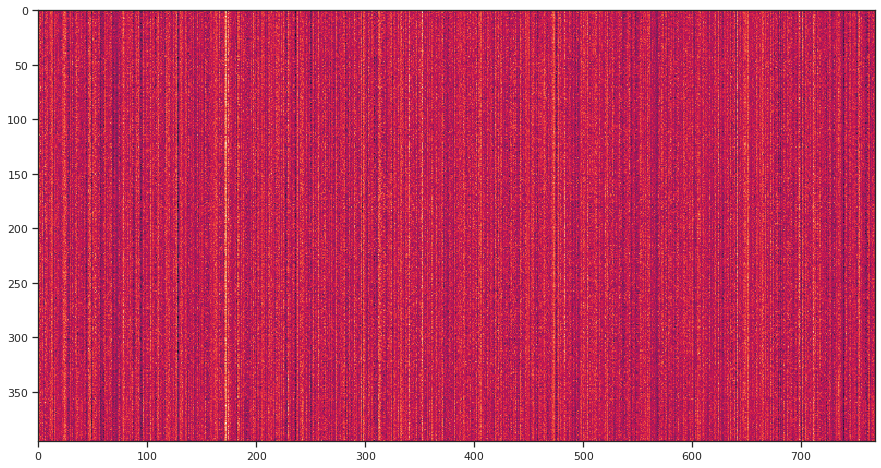

In [0]:
# Visualize the sorted embeddings by relation labels
plt.figure(figsize=(15, 12))
plt.imshow(sent_embs_sorted)
#plt.colorbar()

## There is no difference in terms of the embeddings of the sentences. 
# Extracting the entities and words in between for embeddings.

In [0]:
NYT_test_df_nnd.head(10)

,sentId,articleId,em1,em1label,em1start,em2,em2label,em2start,relation,sentText,relIdx
0,33,2,Tim Pawlenty,PERSON,0,Minnesota,LOCATION,1,/people/person/place_lived,Gov. Tim Pawlenty of Minnesota ordered the sta...,1
1,14,1,Guinea,LOCATION,1,Conakry,LOCATION,2,/location/country/capital,"""The aid group Doctors Without Borders said th...",2
2,44,1,Ben Nelson,PERSON,0,Nebraska,LOCATION,1,/people/person/place_lived,"""The American people can see what is happening...",1
3,10,5,Westchester,LOCATION,4,Mamaroneck,LOCATION,5,/location/location/contains,"""For millions , it was a tough day of coping -...",3
4,1,18,Damascus,LOCATION,3,Syria,LOCATION,1,/location/administrative_division/country,"""The United States maintains diplomatic relati...",4
5,2,27,Florida,LOCATION,4,Boca Raton,LOCATION,3,/location/location/contains,"""Allen J. Ross , President $ -LRB- 6 $ -RRB- G...",3
6,20,0,Peter Bragdon,PERSON,0,Columbia Sportswear,ORGANIZATION,1,/business/person/company,"""It 's irrational , '' said Peter Bragdon , th...",5
7,6,7,Cuba,LOCATION,6,Guantanamo Bay,,0,/location/location/contains,"""In a reminder that the handling of captured t...",3
8,9,4,Rochester,LOCATION,2,George Eastman House,ORGANIZATION,1,/location/location/contains,"""In essence this can start to rewrite the hist...",3
9,2,2,George Stephanopoulos,PERSON,4,ABC News,ORGANIZATION,5,/business/person/company,"""The Democratic presidential contenders are ap...",5


### Clean up the sentText by replacing space before punctuations with '' and replacing \'\' with '

In [0]:
aSent = NYT_test_df_nnd.iloc[6].sentText

In [0]:
import re
aSent = aSent.replace("\'\'", '"').replace("\'", "'").replace("\r", "").replace("\n", "").replace('" ', '"')
re.sub(r'\s+([?.,!\':;])', r'\1',aSent)

'"It\'s irrational, "said Peter Bragdon, the general counsel at Columbia Sportswear, one of the companies suing the government."'

In [0]:
NYT_test_df_nnd.iloc[7]

sentId                                                       6
articleId                                                    7
em1                                                       Cuba
em1label                                              LOCATION
em1start                                                     6
em2                                             Guantanamo Bay
em2label                                                      
em2start                                                     0
relation                           /location/location/contains
sentText     "In a reminder that the handling of captured t...
relIdx                                                       3
Name: 7, dtype: object

In [0]:
NYT_test_df_nnd.iloc[6].sentText

'"It \'s irrational , \'\' said Peter Bragdon , the general counsel at Columbia Sportswear , one of the companies suing the government ."\r\n'

In [0]:
sent = NYT_test_df_nnd.iloc[2].sentText
sent

'"The American people can see what is happening here , \'\' said Senator Ben Nelson , Democrat of Nebraska . \'\'"\r\n'

In [0]:
#Clean up the sentText by replacing space before punctuations with '' and replacing \'\' with '
def cleanSent(aSent):
    sent = aSent.replace("\'\'", '"').replace("\'", "'").replace("\r", "").replace("\n", "").replace('" ', '"')
    sent = re.sub(r'\s+([?.,!\':;])', r'\1',sent)
    return sent

In [0]:
NYT_test_df_nnd['sentTextClnd'] = NYT_test_df_nnd['sentText'].apply(cleanSent)

/home/ubuntu/anaconda3/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
NYT_test_df_nnd.iloc[25].sentTextClnd

'"It was midnight here in Hanoi, or already 2 a.m. back in Seoul, South Korea."'

In [0]:
NYT_test_df_nnd.iloc[25].sentText

'"It was midnight here in Hanoi , or already 2 a.m. back in Seoul , South Korea ."\r\n'

In [0]:
em1 = NYT_test_df_nnd.iloc[2].em1
em1_loc = sent.index(em1)
em1_loc

70

In [0]:
em2 = NYT_test_df_nnd.iloc[2].em2
em2_loc = sent.index(em2)
em2_loc

95

In [0]:
if em1_loc < em2_loc:
    span = sent[em1_loc:em2_loc + len(em2)]
span

'Ben Nelson , Democrat of Nebraska'

## Extract Spans between Two Entity Mentions

In [0]:
NYT_test_df_nnd.columns

Index(['sentId', 'articleId', 'em1', 'em1label', 'em1start', 'em2', 'em2label',
       'em2start', 'relation', 'sentText', 'relIdx', 'sentTextClnd'],
      dtype='object')

In [0]:
# Extract the span between the two nearest entity mentions in the sentence
import re
import math
def spanEMs(sent, em1, em2):
    """
    em1, em2 are two given entity mentions
    """
    em1starts = []
    for m in re.finditer(em1, sent, re.UNICODE):
        em1starts.append(m.start())
    
    em2starts = []
    for m in re.finditer(em2, sent, re.UNICODE):
        em2starts.append(m.start())
    
    loc1 = em1starts[0]
    loc2 = em2starts[0]
    dist = len(sent)
    for s1 in em1starts:
        for s2 in em2starts:
            if s1 != s2:
                if abs(s1-s2) < dist:
                    dist = abs(s1-s2)
                    loc1 = s1
                    loc2 = s2
    #print(loc1, loc2)
    if loc1 < loc2:
        span = sent[loc1:loc2+len(em2)]
        # return the span and the start and end poistions of the span in the sentence
        return span, loc1, loc2+len(em2)
    else:
        span = sent[loc2:loc1+len(em1)]
        # return the span and the start and end poistions of the span in the sentence
        return span, loc2, loc1+len(em1)

In [0]:
NYT_test_df_nnd.iloc[103]

sentId                                                             3
articleId                                                          6
em1                                                      Mexico City
em1label                                                    LOCATION
em1start                                                           1
em2                                                           Mexico
em2label                                                    LOCATION
em2start                                                           0
relation                   /location/administrative_division/country
sentText           "THOUGH the regions of Mexico retain their ver...
relIdx                                                             4
sentTextClnd       "THOUGH the regions of Mexico retain their ver...
sentTextClndUni    "THOUGH the regions of Mexico retain their ver...
Name: 103, dtype: object

In [0]:
NYT_test_df_nnd.iloc[103].sentTextClnd

'"THOUGH the regions of Mexico retain their very distinct cuisines, Mexico City acts like a food processor, puréeing ingredients until you ca n\'t tell what went into the final mix."'

In [0]:
sent = NYT_test_df_nnd.iloc[103].sentTextClnd

In [0]:
span, _, _ = spanEMs(sent, 'Mexico City', 'Mexico')
span

'Mexico retain their very distinct cuisines, Mexico City'

In [0]:
NYT_test_df_nnd.shape

(396, 13)

In [0]:
from unidecode import unidecode

In [0]:
NYT_test_df_nnd['sentTextClndUni'] = NYT_test_df_nnd.sentTextClnd.apply(unidecode)

/home/ubuntu/anaconda3/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
# Extract spans between two entity mentions
spans = []
labels = []
for i in range(NYT_test_df_nnd.shape[0]):
    sent = NYT_test_df_nnd.iloc[i].sentTextClndUni
    try:
        em1 = NYT_test_df_nnd.iloc[i].em1
        em2 = NYT_test_df_nnd.iloc[i].em2
        span, _, _ = spanEMs(sent, em1, em2)
        spans.append(span)
        labels.append(NYT_test_df_nnd.iloc[i].relation)
    except:
        print(sent)

In [0]:
count = 0
for i in range(len(spans)):
    if spans[i] == None:
        count += 1
count

0

In [0]:
len(spans)

396

In [0]:
spans

['Tim Pawlenty of Minnesota',
 'Guinea, Conakry',
 'Ben Nelson, Democrat of Nebraska',
 'Westchester suburbs of Mamaroneck',
 'Syria, but State Department officials say no deeper engagement is warranted until the government in Damascus',
 'Boca Raton, Florida',
 'Peter Bragdon, the general counsel at Columbia Sportswear',
 'Guantanamo Bay, Cuba',
 'George Eastman House in Rochester',
 'George Stephanopoulos of ABC News',
 'Iran and Syria',
 'University of Oregon in Eugene',
 'India, says it will start service to the United States in late August with daily flights to Kennedy International Airport from Delhi',
 'Italy, India',
 'Senegal and Ghana in West Africa',
 'Markus Zusak of Australia',
 'Punjab, in India',
 "France, while London's share of the global art market last year was seven times larger than that of Paris",
 'Panama City Beach, too, has a glut of condos, but the area was one of only two in Florida',
 'Israel and, in its place, the U.N. inserted a new peacekeeping force of s

In [0]:
span_embs = model.encode(spans)


Batches: 100%|██████████| 50/50 [00:12<00:00,  4.12it/s]


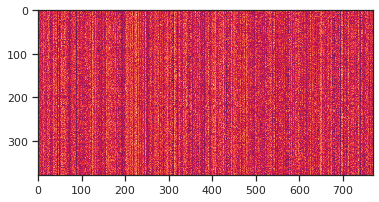

In [0]:
plt.imshow(span_embs)

In [0]:
len(labels)

396

In [0]:
span_embs_pca = PCA(n_components=2).fit_transform(span_embs)
span_embs_pca.shape

(396, 2)

In [0]:
# create a DataFrame for the span embeddings and their relation labels
span_embs_pca_df = pd.DataFrame(span_embs_pca)

In [0]:
span_embs_pca_df.columns = ['coord1', 'coord2']
span_embs_pca_df['rels'] = labels

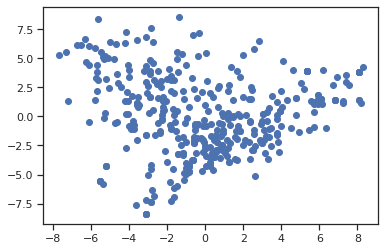

In [0]:
plt.scatter(span_embs_pca[:,0], span_embs_pca[:,1])

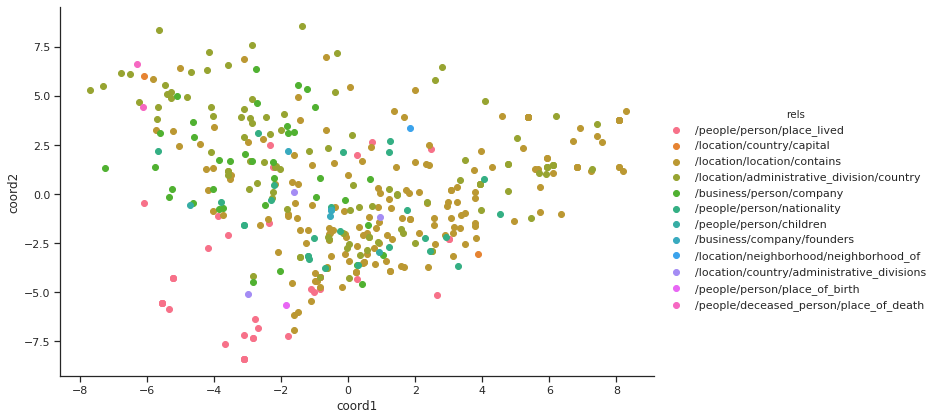

In [0]:
fg = seaborn.FacetGrid(data=span_embs_pca_df, hue='rels', height=6, aspect=1.61)
fg.map(plt.scatter, 'coord1', 'coord2').add_legend()

In [0]:
span_embs_pca_df.groupby('rels').count().sort_values(by = "coord1", ascending=False)

,coord1,coord2
rels,,
/location/location/contains,176,176
/location/administrative_division/country,102,102
/people/person/place_lived,40,40
/business/person/company,37,37
/people/person/nationality,26,26
/business/company/founders,4,4
/location/country/administrative_divisions,3,3
/location/country/capital,2,2
/people/deceased_person/place_of_death,2,2


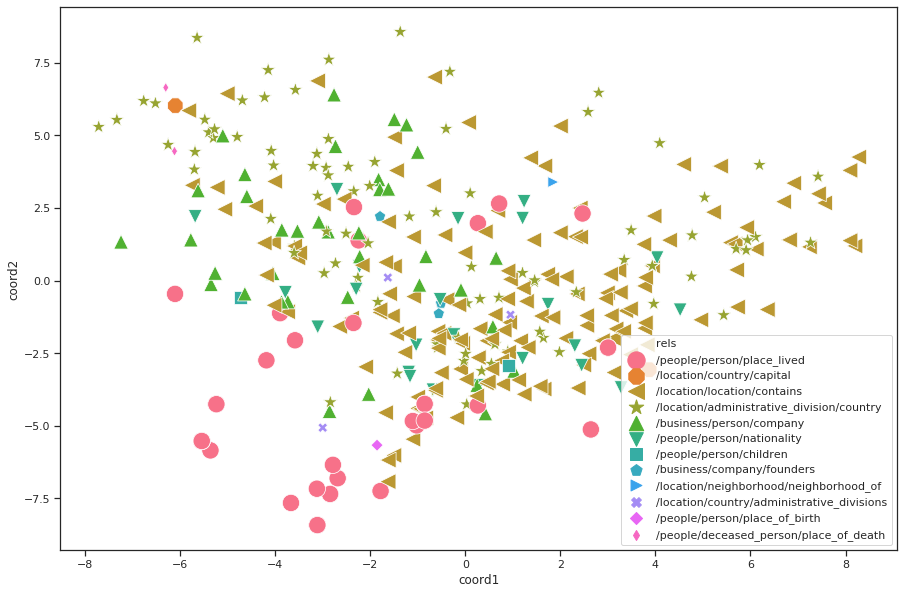

In [0]:
plt.figure(figsize=(15,10))
marker = ['o', '8', '<', '*', '^', 'v', 's', 'p', '>', 'X', 'D', 'd']
markers = [marker[i] for i in range(len(span_embs_pca_df["rels"].unique()))]
sns.scatterplot( x="coord1", y="coord2", data=span_embs_pca_df, hue='rels', style='rels', size='rels', 
                markers=markers, sizes=(50,300))

## Extract Span between Two Entity Mentions along with N Words before and after the Two Mentions

In [0]:
sent = NYT_test_df_nnd.iloc[2].sentText
em1 = NYT_test_df_nnd.iloc[2].em1
em1_loc = sent.index(em1)
em2 = NYT_test_df_nnd.iloc[2].em2
em2_loc = sent.index(em2)
span = ''
if em1_loc < em2_loc:
    span = sent[em1_loc:em2_loc + len(em2)]
    before = sent[:em1_loc].strip()
    before_3 = " ".join(before.split()[-3:])
    after = sent[em2_loc:].strip()
    after_3 = " ".join(after.split()[:3])
    span = before_3 + " " + span + " " + after_3
else:
    span = sent[em2_loc:em1_loc + len(em1)]
    before = sent[:em2_loc].strip()
    before_3 = " ".join(before.split()[-3:])
    after = sent[em1_loc:].trip()
    after_3 = " ".join(after.split()[:3])
    span = before_3 + " " + span + " " + after_3
span

'\'\' said Senator Ben Nelson , Democrat of Nebraska Nebraska . \'\'"'

In [0]:
s = 'here we are'
" ".join(s[0:7].strip().split()[-3:]) + " " + "here"

'here we here'

In [0]:
# Extract before and after n=3 words
def baN(sent, loc1, loc2, n):
    if n==0:
        return '', ''
    else:
        before = sent[0:loc1]
        bN = " ".join(before.strip().split()[-n:])
        after = sent[loc2:]
        aN = " ".join(after.strip().split()[:n])
    
        return bN, aN

In [0]:
sent = NYT_test_df_nnd.iloc[2].sentText
em1 = NYT_test_df_nnd.iloc[2].em1
em1_loc = sent.index(em1)
em2 = NYT_test_df_nnd.iloc[2].em2
em2_loc = sent.index(em2)
span = ''
if em1_loc < em2_loc:
    span = sent[em1_loc:em2_loc + len(em2)]
    bN, aN = baN(sent, em1_loc, em2_loc+len(em2), 2)
    span = bN + " " + span + " " + aN
else:
    span = sent[em2_loc:em1_loc + len(em1)]
    bN, aN = baN(sent, em2_loc, em1_loc+len(em1), 2)
    span = bN + " " + span + " " + aN
span

' Ben Nelson , Democrat of Nebraska '

In [0]:
import sys
# Extract spans between two entity mentions and extra n=3 words before and after
spans_ba = []
labels_ba = []
for i in range(NYT_test_df_nnd.shape[0]):
    try:
        sent = NYT_test_df_nnd.iloc[i].sentTextClnd
        em1 = NYT_test_df_nnd.iloc[i].em1
        em2 = NYT_test_df_nnd.iloc[i].em2
        span, loc1, loc2 = spanEMs(sent, em1, em2)
        bN, aN = baN(sent, loc1, loc2, 1000)
        span = bN + " " + span + " " + aN
        spans_ba.append(span.strip())
        labels_ba.append(NYT_test_df_nnd.iloc[i].relation)
    except:
        continue

In [0]:
len(spans_ba)

379

In [0]:
spans_ba

['Gov. Tim Pawlenty of Minnesota ordered the state health department this month to monitor day-to-day operations at the Minneapolis Veterans Home after state inspectors found that three men had died there in the previous month because of neglect or medical errors.',
 '"The aid group Doctors Without Borders said that since Saturday, more than 275 wounded people had been admitted and treated at Donka Hospital in the capital of Guinea, Conakry ."',
 '"The American people can see what is happening here, "said Senator Ben Nelson, Democrat of Nebraska . ""',
 '"For millions, it was a tough day of coping -- of watching floodwater pour into homes on the Raritan River in New Jersey from New Brunswick to Bound Brook and in the Westchester suburbs of Mamaroneck and New Rochelle, of sleeping in a shelter or an airport, of towing a car and watching a refrigerator float by, of getting to work despite flooded roads and erratic trains, of waiting for power or a water pump or just something to hope for

In [0]:
span_ba_embs = model.encode(spans_ba)

Batches: 100%|██████████| 48/48 [00:39<00:00,  1.23it/s]


In [0]:
span_ba_embs_pca = PCA(n_components=2).fit_transform(span_ba_embs)
span_ba_embs_pca.shape

(379, 2)

In [0]:
# create a DataFrame for the span embeddings and their relation labels
span_ba_embs_pca_df = pd.DataFrame(span_ba_embs_pca)

In [0]:
span_ba_embs_pca_df.columns = ['coord1', 'coord2']
span_ba_embs_pca_df['rels'] = labels_ba

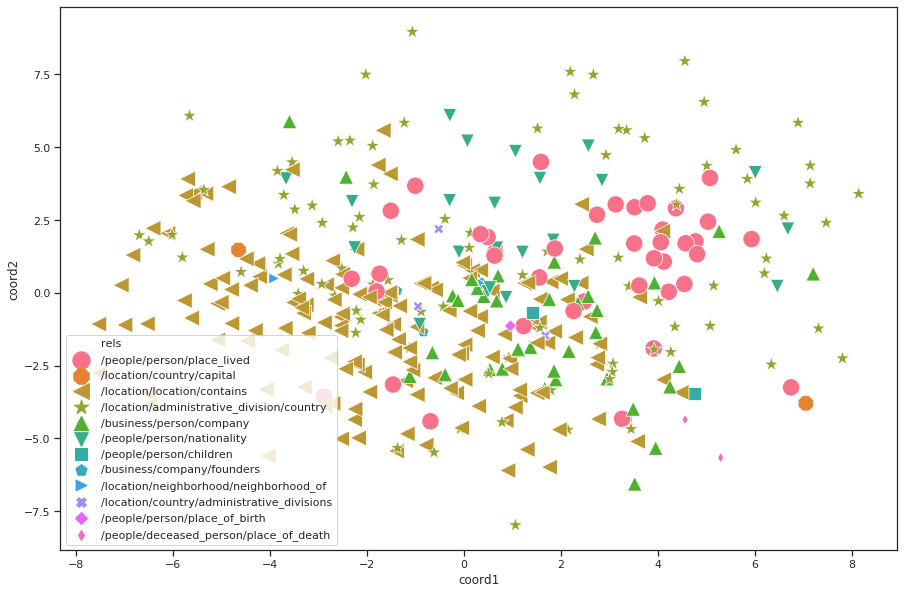

In [0]:
plt.figure(figsize=(15,10))
marker = ['o', '8', '<', '*', '^', 'v', 's', 'p', '>', 'X', 'D', 'd']
markers = [marker[i] for i in range(len(span_ba_embs_pca_df["rels"].unique()))]
sns.scatterplot( x="coord1", y="coord2", data=span_ba_embs_pca_df, hue='rels', style='rels', size='rels', 
                markers=markers, sizes=(50,300))

## Test Clustering Results of the Embeddings

In [0]:
from sklearn import metrics as sk_metrics
from sklearn.cluster import KMeans

In [0]:
len(sent_embs)

396

In [0]:
labels_orig = NYT_test_df_nnd.relation
len(labels_orig)

396

In [0]:
clusts_embs = KMeans(init='k-means++', n_clusters=12, n_init=20, random_state = 21)
km_embs = clusts_embs.fit(np.array(sent_embs))

In [0]:
clusts_labels = km_embs.labels_

rand_score = sk_metrics.adjusted_rand_score(labels_orig, clusts_labels)
rand_score

0.04401304532556506

In [0]:
clusts_span_embs = KMeans(init='k-means++', n_clusters=12, n_init=20, random_state = 21)
km_span_embs = clusts_span_embs.fit(np.array(span_embs))

In [0]:
span_labels = km_span_embs.labels_

rand_score = sk_metrics.adjusted_rand_score(labels, span_labels)
rand_score

0.12883384560674385

In [0]:
pd.Series(labels_ba).nunique()

12

In [0]:
clusts_span_ba_embs = KMeans(init='k-means++', n_clusters=12, n_init=20, random_state = 21)
km_span_ba_embs = clusts_span_ba_embs.fit(np.array(span_ba_embs))

In [0]:
span_ba_labels = km_span_ba_embs.labels_

rand_score = sk_metrics.adjusted_rand_score(labels_ba, span_ba_labels)
rand_score

0.06463399679483071

## Use Rand Index Score to Measure the Sentence Embedding for Sentence Clustering

In [0]:
rand = []
for n in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1000]:
    spans_ba = []
    labels_ba = []
    for i in range(NYT_test_df_nnd.shape[0]):
        sent = NYT_test_df_nnd.iloc[i].sentTextClndUni
        try:
            em1 = NYT_test_df_nnd.iloc[i].em1
            em2 = NYT_test_df_nnd.iloc[i].em2
            span, loc1, loc2 = spanEMs(sent, em1, em2)
            bN, aN = baN(sent, loc1, loc2, n)
            span = bN + " " + span + " " + aN
            spans_ba.append(span.strip())
            labels_ba.append(NYT_test_df_nnd.iloc[i].relation)
        except:
            print(sent)
            
    span_ba_embs = model.encode(spans_ba)
        
    nClusts = pd.Series(labels_ba).nunique()
        
    clusts_span_ba_embs = KMeans(init='k-means++', n_clusters=nClusts, n_init=20, random_state = 21)
    km_span_ba_embs = clusts_span_ba_embs.fit(np.array(span_ba_embs))
        
    span_ba_labels = km_span_ba_embs.labels_
    rand_score = sk_metrics.adjusted_rand_score(labels_ba, span_ba_labels)
    rand.append(rand_score)
    print(rand_score)


Batches: 100%|██████████| 50/50 [00:11<00:00,  4.17it/s]


0.12883384560674385



Batches: 100%|██████████| 50/50 [00:13<00:00,  3.81it/s]


0.09386894463638336



Batches: 100%|██████████| 50/50 [00:15<00:00,  3.27it/s]


0.11148525208842608



Batches: 100%|██████████| 50/50 [00:16<00:00,  2.96it/s]


0.0662770549973419



Batches: 100%|██████████| 50/50 [00:17<00:00,  2.87it/s]


0.09166031141194178



Batches: 100%|██████████| 50/50 [00:19<00:00,  2.53it/s]


0.07574509353151361



Batches: 100%|██████████| 50/50 [00:20<00:00,  2.41it/s]


0.09917875239326832



Batches: 100%|██████████| 50/50 [00:21<00:00,  2.29it/s]


0.11363843947364281



Batches: 100%|██████████| 50/50 [00:23<00:00,  2.12it/s]


0.10906804276463732



Batches: 100%|██████████| 50/50 [00:23<00:00,  2.15it/s]


0.053625055770046864



Batches: 100%|██████████| 50/50 [00:25<00:00,  1.97it/s]


0.09115842230309541



Batches: 100%|██████████| 50/50 [00:37<00:00,  1.33it/s]


0.05527599811365532


In [0]:
rand

[0.12883384560674385,
 0.09386894463638336,
 0.11148525208842608,
 0.0662770549973419,
 0.09166031141194178,
 0.07574509353151361,
 0.09917875239326832,
 0.11363843947364281,
 0.10906804276463732,
 0.053625055770046864,
 0.09115842230309541,
 0.05527599811365532]

Text(0, 0.5, 'Rand Score')

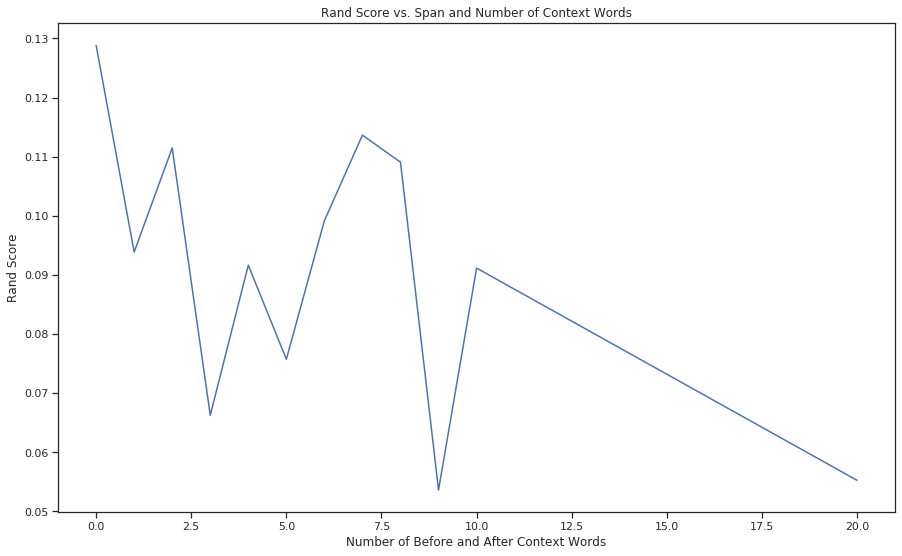

In [0]:
plt.figure(figsize=(15,9))
plt.plot([0,1,2,3,4,5,6,7,8,9,10,20], rand)
plt.title("Rand Score vs. Span and Number of Context Words")
plt.xlabel("Number of Before and After Context Words")
plt.ylabel('Rand Score')